# FIRST TASK

## Preliminary steps

Import the libraries

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import glob

Utility functions:
- **plot_images** : plots the images
- **get_img_filenames** : to generate the images filenames

In [5]:
def plot_images(images,title="",color=False,rgb=True):
    for i in range(len(images)):
        plt.subplot(1,N,i+1).axis("off")
        if color and rgb : 
            plt.imshow(images[i])
        elif color and rgb==False:
            plt.imshow(cv.cvtColor(images[i],cv.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.show()

def get_img_filenames(task,start_dir='..'):
    nir_img_filenames = []
    rgb_img_filenames = []
    if task == 'first_task':
        for y in range(1,4):
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'second_task':
        for y in 4,5:
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'final_challenge':
        for y in range(6,11) :
            if(y>=10):
                nir_img_filenames.append("{}/imgs/{}/C0_0000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_0000{}.png".format(start_dir,task,y))
            else:
                nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))

    return nir_img_filenames, rgb_img_filenames

def get_samples_filenames(start_dir='..'):
    samples = []
    for sample in glob.glob('{}/imgs/second_task/samples/sample_*.png'.format(start_dir)):
        samples.append(sample)
    return samples

Reading the images

In [8]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("first_task")
N = len(nir_img_filenames)

nir_img = []
rgb_img = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.imread(rgb_img_filenames[i]))

## Create a **Binary Mask** to outline the fruits 

I want to create a binary mask of the fruit in order to outline it.

First, I used a global thresholding approach, using Otsu's method to calculate the threshold.

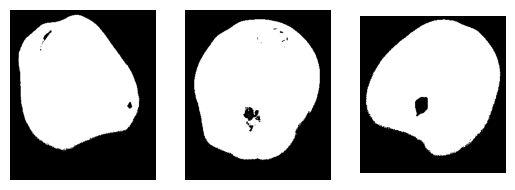

In [9]:
im_th = []

for i in range(N):
    _, im_thresh = cv.threshold(nir_img[i],None,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    im_th.append(im_thresh)
plot_images(im_th)    

As you can see in the image above, it works pretty well, but it isn't a super accurate segmentation because some parts of the apples are considered as backgorund. For example, in first and third image the stalk of the apple and the region around are not considered as foreground. For some applications this segmentation can be enough, but I decided to detect more accurately the shapes of the apples.

This happens because the light isn't uniform in the images.

For this reason I decided to use **ADAPTIVE THRESHOLDING** which computes a binarization threshold at each image pixel, based on the intensities within a small neighbourhood. This type of thresholding can handle also images without uniform lighting across the scene.

Before thresholding I apply a bilateral filter in order to denoise image without smoothing (preserving edges).

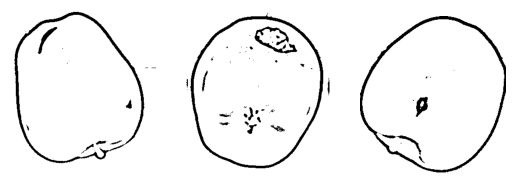

In [32]:
im_th = []
filled = []
for i in range(N):
    im_th.append(cv.bilateralFilter(nir_img[i],7,45,45))
    im_th[i] = cv.adaptiveThreshold(im_th[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,15,3)

plot_images(im_th)

I invert the image in order to have the foreground pixels with value = 255 (white) and background pixels with value = 0 (black).

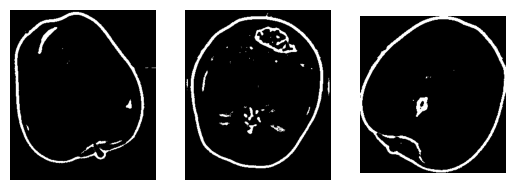

In [33]:
for i in range(N):
    im_th[i] = cv.bitwise_not(im_th[i])
plot_images(im_th)

I find the contours of the apple selecting the connected components having the largest bounding box. Indeed, excluding the background (label having index equal to 0), the component having the largest bounding box has to be the apple because I assume that no bigger components can be detected. In practice I am assuming that every image contains an apple that covers almost all the image. This assumption is respected for each of the three images, and even if we had more images it's likely that they contained a single 'big' apple.

To extract informations about connected components in the binary mask, I use **cv.connectedComponentsWithStats** function which computes the connected components labeled image of binary image and also produces a statistics output for each label.

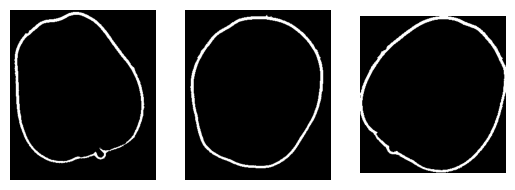

In [34]:
binary_mask = []
for i in range(N):
    
    # numLabels = number of connected components
    # labels = labeled image
    # stats = 	statistics output for each label
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(im_th[i], 4)
    max_area = -np.inf
    j_mask = -1
    
    # iterate over labels, excluding labels[0] which is the background
    for j in range(1,numLabels):

        # w = horizontal size of the bounding box
        # h = vertical size of the bounding box 
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)
plot_images(binary_mask)

**FILLING THE SPACE INSIDE THE FRUIT BLOB USING A FLOOD FILL APPROACH**

The **cv.floodFill** function fills a connected component starting from the seed point with the specified color.  
This function requires an operation mask that should be a single-channel 8-bit image, 2 pixels wider and 2 pixels taller than image. 

Starting from the previous assumption, that each image contains a single 'big' apple, I caan also suppose that the central pixel of the image will belong to the apple. So I can use this point as seed for the flood filling. 

After the flood filling I obtain the binary mask of the apple.

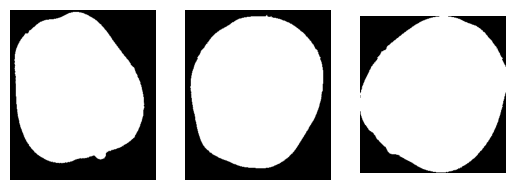

In [35]:
op_mask = []
for i in range(N):
    h, w = binary_mask[i].shape[:2]
    
    # Operation mask has to be 2 pixels wider and 2 pixels taller than image
    op_mask.append(np.zeros((h+2, w+2), np.uint8))

    # floodfilling starting from the center of the image
    cv.floodFill(binary_mask[i], op_mask[i], (int(h/2),int(w/2)), 255)
plot_images(binary_mask)

Apply the mask to NIR img.

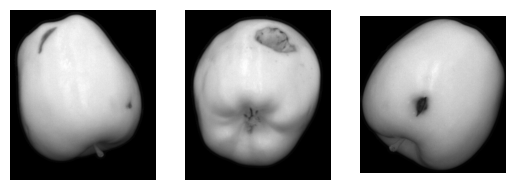

In [36]:
nir_fruit = []
for i in range(N):
    nir_fruit.append(cv.bitwise_and(nir_img[i],nir_img[i],mask=binary_mask[i]))
plot_images(nir_fruit,color=True,rgb=False)

Find the contours of the apple from the binary mask, and draw them into the color image.

I use **cv.findContours** function that retrieves contours from a binary image:
- *binary_mask* : the binary image i want to process
- *cv.RETR_TREE* : (mode of the contour retrieval algorithm) retrieves all of the contours and reconstructs a full hierarchy of nested contours.
- *cv.CHAIN_APPROX_SIMPLE*: (the contour approximation algorithm) It removes all redundant points and compresses the contour. Instead *cv.CHAIN_APPROX_NONE* stores all the contour points using more memory. I try both retrieval algorithms and I can't see particular differences using one or another, so I decide to use the one that saves more memory.

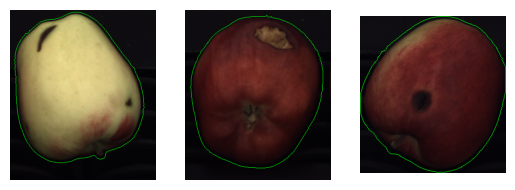

In [37]:
contours = []
output = []

for i in range(N):
    output.append(rgb_img[i].copy())
    cont, _ =  cv.findContours(binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(cont)
    cv.drawContours(output[i], contours[i], -1, (0,255,0), 1)

plot_images(output,color=True,rgb=False)



## Defects search

Now I want to detect defects for each apple. As suggested in the assignment I use **Canny** to detect defects' edges.

Before applying Canny I denoise the NIR image.

Without filtering the image , we notice that a lot of spurious edges, not correlated with fruit contours or defects' contours, are detected by Canny.

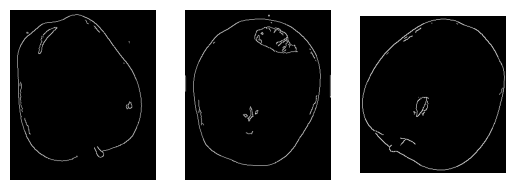

In [38]:
edges = []
for i in range(N): 
    edges.append(cv.Canny(nir_img[i],60,120))

plot_images(edges)

Applying a bilateral filter before Canny, only fruit external edges and defects edges appears.I use a **Bilateral Filter** to denoise the image, without blurring the edges. The values of *d* (Diameter of each pixel neighborhood that is used during filtering ) and *sigma* (filter sigma in color and coordinate space) were choosen after some empirical attempts.

The **cv.Canny** function computes edges given an input image and the values of the two thresholds for hysteresis procedure. Also this parameters were tuned after some empirical attempts

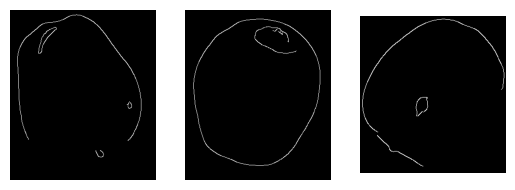

In [39]:
d = 9
sigma = 50
blurred_nir_fruit = []
for i in range(N):
    blurred_nir_fruit.append(cv.bilateralFilter(nir_fruit[i],d,sigma,sigma))
    edges[i] = cv.Canny(blurred_nir_fruit[i],60,120)

plot_images(edges)

Now, I want to mantain only defects' edges. I use the **Dilation** morphology operator to dilate the background. Then, I subract it to the edges detected by Canny to remove the external edges of the fruit and keep only defects' edges.

In OpenCV you can create structuring elements using **cv.getStructuringElement** function,  passing it the shape and the dimension of the structuring element you want to use. In this case I choose an elliptic structuring element because the defects have a circular shape.

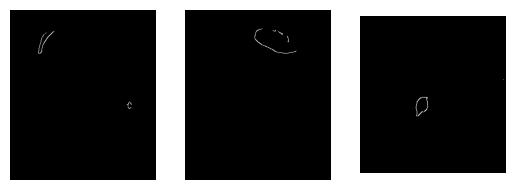

In [40]:
background = []
background_dilated = []
edges_intern = []
for i in range(N):

    # extract the background
    background.append(255 - binary_mask[i])

    # dilate the background
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11)),iterations = 5))
    edges_intern.append(cv.subtract(edges[i],background_dilated[i]))

plot_images(edges_intern)

To obtain a binary mask fro the defects I use **Closing** morphological operator to "close" the foreground objects (defects). Again, I use a structuring element with an elliptical shape for the reasons explained above.

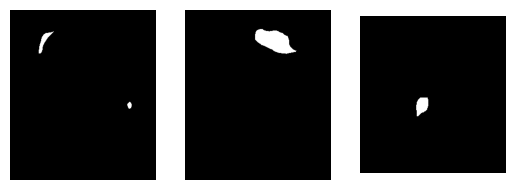

In [41]:
structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40, 40))
defects_binary_mask = []
for i in range(N):
    defects_binary_mask.append(cv.morphologyEx(edges_intern[i], cv.MORPH_CLOSE, structuringElement))

plot_images(defects_binary_mask)

Now I have a binary image in which connected components are the defects. So, to detect how much defects are there in the image, I use again the **cv.connectedComponentsWithStats** function.

In [42]:

for i in range(N):
    (numLabels, _, _, _) = cv.connectedComponentsWithStats(defects_binary_mask[i], 4)

    # Subtracting by one because the first connected component is the background
    print("Total defects detected in image{} : {}".format(i,numLabels-1))

Total defects detected in image0 : 2
Total defects detected in image1 : 1
Total defects detected in image2 : 1


Finally, I found the contours of the connected components representing the defects and I higlight them in red.

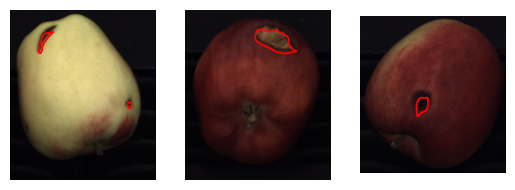

In [43]:
contours = []
output = []

for i in range(N):
    output.append(rgb_img[i].copy())
    contour, _ = cv.findContours(defects_binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours.append(contour)
    cv.drawContours(output[i], contours[i], -1, (0,0,255), 2)

plot_images(output,color=True,rgb=False)



# SECOND TASK

## Preliminary steps

Utility functions

Reading the images

In [57]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("second_task")
samples_filenames = get_samples_filenames()
N = len(nir_img_filenames)

nir_img = []
rgb_img = []
samples = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.cvtColor(cv.imread(rgb_img_filenames[i]),cv.COLOR_BGR2RGB))
for i in range(len(samples_filenames)):
    samples.append(cv.cvtColor(cv.imread(samples_filenames[i]),cv.COLOR_BGR2RGB))

## Binary mask of the fruit

First, I create a binary mask of the apple. I follow the same steps of TASK1, so refer to TASK1 for details.

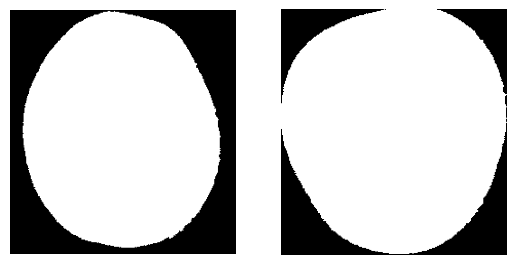

In [47]:
im_th = []
filled = []
binary_mask = []
op_mask = []
for i in range(N):
    # bilateral filter
    im_th.append(cv.bilateralFilter(nir_img[i],7,45,45))

    #adaptive threshold
    im_th[i] = cv.adaptiveThreshold(nir_img[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,15,3)

    # invert the image
    im_th[i] = cv.bitwise_not(im_th[i])

    # connected components labeling
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(im_th[i], 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)

    # fill holes inside the mask
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    cv.floodFill(binary_mask[i], op_mask[i], (125,125), 255)

plot_images(binary_mask)

## Colour-based segmentation to detect russets

To detect russets, I calculate the Mahalanobis distance from each pixel to a reference colour which I estimate using a set of samples. I suppose that some samples are given to me in order to estimate a reference colour. In practice I use this [script](../others/extract_samples.py) to extract them from images.

I choose to use **LUV** which is a **perceptually uniform** colorspace. This means that a change in any direction of the color space is perceived by a human as the same change.  Instead color difference, in RGB space, do not correspond well to perceived differences in color. That is, two colors can be close in RGB space but appear very different to humans and vice versa.

Moreover,  LUV decouple the "color" (chromaticity, the UV part) and "lightness" (luminance, the L part) of color. So I calculate the reference color just based on the UV part, which gives invariance to changes in lighting condition.

First, I convert samples and the image under analysis into the LUV colorspace.

In [48]:
luv_samples = []
for i in range(len(samples)):
    luv_samples.append(cv.cvtColor(samples[i],cv.COLOR_RGB2LUV))
luv_img = []
for i in range(len(rgb_img)):
    luv_img.append(cv.cvtColor(rgb_img[i],cv.COLOR_RGB2LUV))


### Estimating the reference colour
I iterate over samples and for each of them I calculate the *covariance matrix* and the mean vector using **cv.calcCovarMatrix** function, in particular:
- *sample_reshaped* : N x 2 matrix of samples containing in each row the U and V component of each sample. For each iteration I pass the sample extracted by me (now I call it "crop") and the function calculates covariance matrix and mean vector considering as "single sample" each pixel of the crop. Before passing it to the function I have to process my crop in order to consider only U and V component and to reshape it into a Nx2 matrix. 
- *flags* 
    - *COVAR_ROWS* : to specify to the function to consider as input vectors (single samples), the rows of the input matrix(*sample_reshaped*)
    - *COVAR_NORMAL* : specify how the covariance matrix will be calculated
    - *COVAR_SCALE* : if the flag is specified, the covariance matrix is scaled. In the "normal" mode, scale is 1./nsamples.

I accumulate "total mean" and "total covariance" into two arrays.

Finally I calculate the **reference colour** as the *mean of the mean vectors* calculated by the calcCovarMatrix function for each sample.

In [49]:
# prepare the arrays 
reference_color = np.zeros((1,2),dtype=np.float64)
mean_tot = np.zeros((1,2),dtype=np.float64)
covar_tot =  np.zeros((2,2),dtype=np.float64)

for i in range(len(luv_samples)):
    
    # consider only UV part and reshape into a Nx2 matrix
    sample_reshaped = luv_samples[i][:,:,1:3].reshape(luv_samples[i].shape[0]*luv_samples[i].shape[1],2)

    # calculate covariance matrix and mean vector
    covar, mean = cv.calcCovarMatrix(sample_reshaped,None,flags=cv.COVAR_ROWS | cv.COVAR_NORMAL | cv.COVAR_SCALE)

    # accumulate
    mean_tot += mean
    covar_tot += covar

reference_color = mean_tot/len(luv_samples)


I calculate the **inverse of the covariance matrix** using the *Singular Value Decomposition* Method, as suggested in OpenCV documentation. Then I compute a pixel wise Mahalanobis distance (considering only pixels belonging to the binary mask of the apple to be more efficient) using the **cv.Mahalanobis** function which takes as inputs two 1D arrays and the inverse covariance matrix (computed preferrably using the SVD method). A pixel belongs to a russet if its Mahalanobis distance from the reference colour is less than a threshold, selected after some empirical attempts. 

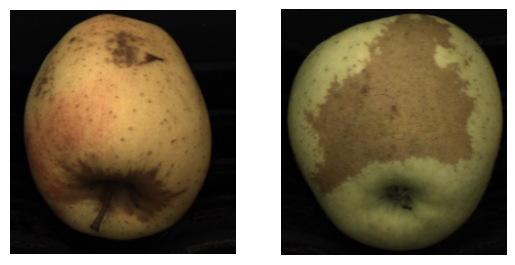

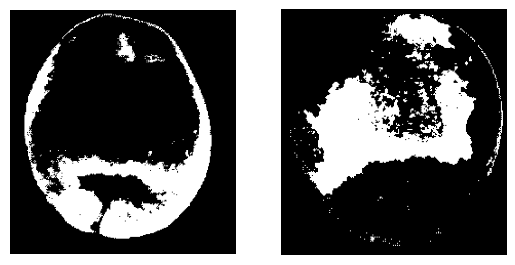

In [50]:
# invert the covariance matrix
inv_cov = cv.invert(covar_tot, cv.DECOMP_SVD)

russets = []
for x in range(len(luv_img)):
    russet = np.zeros((luv_img[x].shape[0],luv_img[x].shape[1]),dtype = np.uint8)
    for i in range(luv_img[x].shape[0]):
        for j in range(luv_img[x].shape[1]):

            # consider only pixels belonging to the binary mask
            if binary_mask[x][i][j]==255:

                # compute the Mahalanobis distance
                mahal_dst = cv.Mahalanobis(np.float64(reference_color.flatten()),np.float64(luv_img[x][i,j,1:3]),inv_cov[1])

                # if the distance is less than a threshold, the pixel belongs to a russet
                if mahal_dst<1.5:
                    russet[i,j]=255
    russets.append(russet)

plot_images(rgb_img,color=True,rgb=True)
plot_images(russets,color=False)


I obtain a binary mask of the russets, which isn't super accurate. To refine the mask I apply some morphological operations. 

At first I dilate the background (as I did in TASK1) to delete pixels wrongly detected as russets which belong to the contours of the apple. This probably happens because light isn't uniform in the scene and so along borders pixels are darker and their Mahalanobis distance results smaller as it really is.

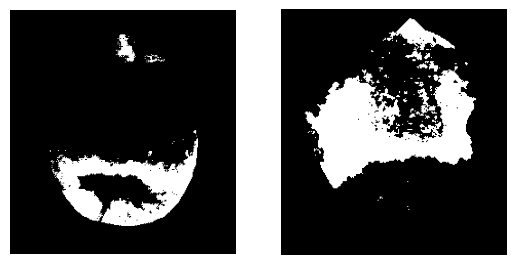

In [51]:
background = []
background_dilated = []
russet_without_borders = []
for i in range(len(luv_img)):
    background.append(255 - binary_mask[i])
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,13)),iterations = 4))
    russet_without_borders.append(cv.subtract(russets[i],background_dilated[i]))

plot_images(russet_without_borders)

Then I close the background in order to obtain a "filled" binary mask of the russet.

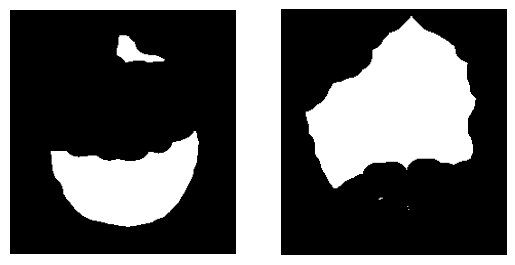

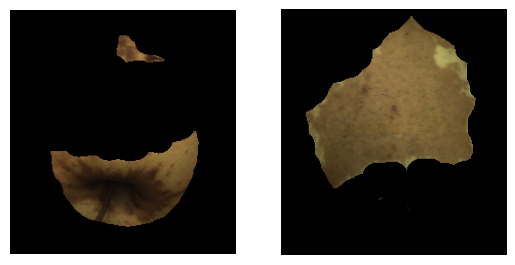

In [52]:
final_russet = []
russets_rgb = []

structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (30, 30))
for i in range(len(luv_img)):
    # close the background
    final_russet.append(cv.morphologyEx(russet_without_borders[i], cv.MORPH_CLOSE, structuringElement))

    # apply the binary mask to RGB image
    russets_rgb.append(cv.bitwise_and(rgb_img[i],rgb_img[i],mask=final_russet[i]))

plot_images(final_russet)
plot_images(russets_rgb,color=True,rgb=True)

I apply connected components labeling in order to outline the defects in the RGB image. Connected components too small are not considered beacuse they can be false positives. 

In [10]:
output = []
for i in range(len(luv_img)):
    (numLabels,labels, stats, centroids) = cv.connectedComponentsWithStats(final_russet[i], 4)
    output.append(cv.cvtColor(luv_img[i].copy(),cv.COLOR_LUV2RGB))
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[j]
        area = stats[j, cv.CC_STAT_AREA]
        
        # too small connected components are not considered
        if (area>10):
            cv.circle(output[i], (int(cX), int(cY)), int(w/2), (255, 0, 0), 2)

plot_images(output,color=True,rgb=True)


NameError: name 'luv_img' is not defined